In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as PathEffects
import numpy as np
import pandas as pd
import seaborn as sns
import pyBigWig
import pybedtools
import re
import os

# --- Helper Functions ---

def parse_region(region_str):
    """Parses 'chr:start-end' string into (chrom, start, end)."""
    # Remove commas if present
    region_str = region_str.replace(',', '')
    chrom, coords = region_str.split(':')
    start, end = map(int, coords.split('-'))
    return chrom, start, end

def smooth_signal(y, window=20):
    """Smooths a signal using a rolling window convolution."""
    if len(y) < window:
        return y
    box = np.ones(window) / window
    # mode='same' keeps the array length consistent
    return np.convolve(y, box, mode='same')

def get_gtf_features(gtf_file, chrom, start, end):
    """
    Extracts gene models from a GTF file for a specific region using pybedtools.
    Returns a DataFrame of features.
    """
    if not gtf_file:
        return pd.DataFrame()
    
    # Create a query interval
    query = pybedtools.BedTool(f'{chrom} {start} {end}', from_string=True)
    gtf = pybedtools.BedTool(gtf_file)
    
    # Intersect
    hits = gtf.intersect(query, wa=True)
    
    if len(hits) == 0:
        return pd.DataFrame()
        
    # Convert to dataframe
    # GTF columns: seqname, source, feature, start, end, score, strand, frame, attribute
    df = hits.to_dataframe(names=[
        'chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attributes'
    ])
    
    # Simple attribute parser for gene_name
    def parse_attr(attr_str, key):
        m = re.search(f'{key} "([^"]+)"', attr_str)
        return m.group(1) if m else None

    df['gene_name'] = df['attributes'].apply(lambda x: parse_attr(x, 'gene_name'))
    return df

# --- Main Plotting Function ---

def plot_genome_regions(bigwigs,
                        selected_regions,
                        gtf_file=None,
                        bed_tracks=None,
                        colors=None,
                        track_names=None,
                        ymin=0, ymax=75,
                        figsize=(12, 10),
                        smooth_window=20,
                        saveas=None):
    """
    bigwigs: list of paths to .bw files
    selected_regions: dict {Label: "chr:start-end"}
    gtf_file: path to .gtf file
    bed_tracks: list of paths to .bed files for annotation tracks
    colors: list of colors for the bigwig tracks
    """
    
    # 1. Setup Data Structures
    region_labels = list(selected_regions.keys())
    region_coords = [parse_region(r) for r in selected_regions.values()]
    n_regions = len(region_labels)
    
    n_bw = len(bigwigs)
    n_bed = len(bed_tracks) if bed_tracks else 0
    has_gtf = 1 if gtf_file else 0
    
    if track_names is None:
        track_names = [os.path.basename(x).replace('.bigWig', '').replace('.bw', '') for x in bigwigs]
    
    if colors is None:
        colors = ['#333333'] * n_bw
    elif len(colors) < n_bw:
        # Recycle colors if not enough provided
        from itertools import cycle
        colors = [c for c, _ in zip(cycle(colors), range(n_bw))]

    # 2. Setup Figure and Grid
    # Rows = BigWigs + BedTracks + GTF
    total_rows = n_bw + n_bed + has_gtf
    
    # Define relative heights: BigWigs get 1.0, Beds get 0.3, GTF gets 0.5
    height_ratios = [1.0] * n_bw + [0.3] * n_bed + ([0.5] if has_gtf else [])
    
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(total_rows, n_regions, 
                           height_ratios=height_ratios, 
                           wspace=0.1, hspace=0.3)

    # 3. Plot BigWig Tracks
    for row_idx, (bw_file, track_name, color) in enumerate(zip(bigwigs, track_names, colors)):
        bw = pyBigWig.open(bw_file)
        
        for col_idx, (label, (chrom, start, end)) in enumerate(zip(region_labels, region_coords)):
            ax = fig.add_subplot(gs[row_idx, col_idx])
            
            # Fetch Data
            try:
                # pyBigWig usually expects 'chr1', ensure consistency
                if chrom not in bw.chroms() and ('chr'+chrom) in bw.chroms():
                    chrom_bw = 'chr'+chrom
                else:
                    chrom_bw = chrom
                    
                values = bw.values(chrom_bw, start, end)
                values = np.nan_to_num(np.array(values)) # Handle NaNs
                
                # Smooth
                if smooth_window:
                    values = smooth_signal(values, smooth_window)
                
                x_axis = np.arange(start, end)
                
                # Plot Area
                ax.fill_between(x_axis, values, color=color, alpha=0.9, linewidth=0)
                
            except Exception as e:
                print(f"Error reading {chrom}:{start}-{end} from {bw_file}: {e}")
            
            # Styling
            ax.set_ylim(ymin, ymax)
            ax.set_xlim(start, end)
            
            # Ticks and Labels
            if col_idx == 0:
                ax.set_ylabel(track_name, rotation=0, ha='right', va='center', fontsize=12)
            
            # Hide x-axis for all but the very last row (if no annotations exist)
            if row_idx < total_rows - 1:
                ax.set_xticks([])
            else:
                # If this is the last row overall (no bed/gtf), format x-axis
                ax.tick_params(axis='x', labelsize=8)
            
            ax.set_yticks([]) # Simplify y-axis (optional: keep specific ticks)
            sns.despine(ax=ax, left=True, bottom=(row_idx < total_rows - 1))

        bw.close()

    current_row = n_bw

    # 4. Plot Bed Tracks (Subtracks)
    if bed_tracks:
        for bed_file in bed_tracks:
            # Load bed file once
            bed_tool = pybedtools.BedTool(bed_file)
            
            for col_idx, (label, (chrom, start, end)) in enumerate(zip(region_labels, region_coords)):
                ax = fig.add_subplot(gs[current_row, col_idx])
                
                # Intersect
                region_query = pybedtools.BedTool(f'{chrom} {start} {end}', from_string=True)
                hits = bed_tool.intersect(region_query, wa=True)
                
                # Plot bars
                y_pos = 0
                for hit in hits:
                    h_start = max(start, hit.start)
                    h_end = min(end, hit.end)
                    ax.hlines(y_pos, h_start, h_end, linewidth=6, color='#555555')
                    
                    # Add Text Label
                    if hasattr(hit, 'name'):
                        txt = ax.text((h_start+h_end)/2, y_pos+0.2, hit.name, 
                                      ha='center', va='bottom', fontsize=8)
                        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
                
                ax.set_xlim(start, end)
                ax.set_ylim(-1, 2)
                ax.axis('off')
            
            current_row += 1

    # 5. Plot GTF / Gene Models
    if has_gtf:
        for col_idx, (label, (chrom, start, end)) in enumerate(zip(region_labels, region_coords)):
            ax = fig.add_subplot(gs[current_row, col_idx])
            
            df = get_gtf_features(gtf_file, chrom, start, end)
            
            if not df.empty:
                # Get Genes to determine Y positions
                genes = df[df['feature'] == 'gene']['gene_name'].unique()
                
                for i, gene in enumerate(genes):
                    gene_data = df[df['gene_name'] == gene]
                    y_pos = i  # Stack genes vertically if overlapping
                    
                    # Plot full gene extent (thin line)
                    gene_start = gene_data['start'].min()
                    gene_end = gene_data['end'].max()
                    ax.plot([max(start, gene_start), min(end, gene_end)], [y_pos, y_pos], 
                            color='black', linewidth=1)
                    
                    # Plot Exons (thick lines)
                    exons = gene_data[gene_data['feature'] == 'exon']
                    for _, exon in exons.iterrows():
                        ax.plot([max(start, exon['start']), min(end, exon['end'])], 
                                [y_pos, y_pos], 
                                color='black', linewidth=6)
                    
                    # Label
                    txt = ax.text(max(start, gene_start), y_pos + 0.2, gene, 
                                  fontsize=10, style='italic', ha='left')
                    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
            
            ax.set_xlim(start, end)
            ax.axis('off')
            # Add column title at the very top (Region Label)
            # We access the top-most axes to set the title
            top_ax = fig.get_axes()[col_idx]
            top_ax.set_title(label, fontsize=14, pad=10)

    # 6. Save or Show
    plt.tight_layout()
    if saveas:
        plt.savefig(saveas, dpi=300, bbox_inches='tight')
        print(f"Saved plot to {saveas}")
    else:
        plt.show()

# --- Example Usage ---
# regions = {
#     "GeneA_Promoter": "chr2L:1000-5000",
#     "GeneB_Enhancer": "chrX:20000-25000"
# }
# bigwigs = ["/path/to/file1.bw", "/path/to/file2.bw"]
# plot_genome_regions(bigwigs, regions, gtf_file="/path/to/genes.gtf")

In [2]:
import os

In [3]:
from pathlib import Path

directory = Path("bigwigs_filter/enterocytes")

# This gives you absolute paths automatically
files = [f.absolute() for f in directory.iterdir()]

# If you only want the string version of the path:
file_strings = [str(f.absolute()) for f in directory.iterdir()]

In [4]:
regions = {
    "WNT9A": "chr1:227,936,813-227,970,089",
    
}

In [5]:
bigwigs = file_strings

In [9]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as PathEffects
import numpy as np
import pandas as pd
import seaborn as sns
import pyBigWig
import pybedtools
import re
import os

# --- Helper Functions ---

def parse_region(region_str):
    """Parses 'chr:start-end' string into (chrom, start, end)."""
    region_str = region_str.replace(',', '')
    chrom, coords = region_str.split(':')
    start, end = map(int, coords.split('-'))
    return chrom, start, end

def smooth_signal(y, window=20):
    if len(y) < window: return y
    box = np.ones(window) / window
    return np.convolve(y, box, mode='same')

def check_chrom_format(bedtool_obj, chrom):
    """
    Checks if the BedTool object (GTF) uses 'chr' prefix.
    Returns the chromosome name formatted to match the file.
    """
    # Peek at the first few lines of the GTF to guess convention
    try:
        first_interval = next(iter(bedtool_obj))
        file_has_chr = first_interval.chrom.startswith('chr')
        query_has_chr = chrom.startswith('chr')
        
        if file_has_chr and not query_has_chr:
            return 'chr' + chrom
        elif not file_has_chr and query_has_chr:
            return chrom.replace('chr', '')
        return chrom
    except StopIteration:
        return chrom

def get_gtf_features(gtf_file, chrom, start, end):
    """
    Extracts gene models. Now includes chromosome format checking.
    """
    if not gtf_file: return pd.DataFrame()
    
    gtf = pybedtools.BedTool(gtf_file)
    
    # fix chromosome naming convention (e.g. 1 vs chr1)
    chrom_query = check_chrom_format(gtf, chrom)
    
    # Create query and intersect
    query_str = f'{chrom_query} {start} {end}'
    query = pybedtools.BedTool(query_str, from_string=True)
    
    # Use simple intersection
    hits = gtf.intersect(query, wa=True)
    
    if len(hits) == 0:
        print(f"No GTF features found for {chrom_query}:{start}-{end}")
        return pd.DataFrame()
        
    # Convert to dataframe
    # GTF columns: seqname, source, feature, start, end, score, strand, frame, attribute
    df = hits.to_dataframe(names=[
        'chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attributes'
    ])
    
    # Robust attribute parser
    def parse_attr(attr_str, key):
        # regex for: key "value"; OR key value;
        m = re.search(f'{key}\s+"?([^";]+)"?', attr_str)
        return m.group(1) if m else None

    # Try 'gene_name', fallback to 'gene_id' or 'transcript_id'
    df['gene_name'] = df['attributes'].apply(lambda x: parse_attr(x, 'gene_name'))
    mask_nan = df['gene_name'].isna()
    if mask_nan.any():
        df.loc[mask_nan, 'gene_name'] = df.loc[mask_nan, 'attributes'].apply(lambda x: parse_attr(x, 'gene_id'))

    return df

# --- Main Plotting Function ---

def plot_genome_regions(bigwigs,
                        selected_regions,
                        gtf_file=None,
                        bed_tracks=None,
                        colors=None,
                        track_names=None,
                        ymin=0, ymax=75,
                        figsize=(12, 10),
                        smooth_window=20,
                        saveas=None):
    
    # 1. Setup Data
    region_labels = list(selected_regions.keys())
    region_coords = [parse_region(r) for r in selected_regions.values()]
    n_regions = len(region_labels)
    n_bw = len(bigwigs)
    n_bed = len(bed_tracks) if bed_tracks else 0
    has_gtf = 1 if gtf_file else 0
    
    if track_names is None:
        track_names = [os.path.basename(x).split('.')[0] for x in bigwigs]
    
    if colors is None:
        colors = ['#333333'] * n_bw
    elif len(colors) < n_bw:
        from itertools import cycle
        colors = [c for c, _ in zip(cycle(colors), range(n_bw))]

    # 2. Setup Figure
    total_rows = n_bw + n_bed + has_gtf
    # Ratios: BigWigs=1, Bed=0.2, GTF=0.5
    height_ratios = [1.0] * n_bw + [0.2] * n_bed + ([0.5] if has_gtf else [])
    
    fig = plt.figure(figsize=figsize)
    
    # Use hspace=0 to stack them tight, we will handle separation via spines/ticks
    gs = gridspec.GridSpec(total_rows, n_regions, 
                           height_ratios=height_ratios, 
                           wspace=0.1, hspace=0.15) # hspace controls gap between tracks

    # 3. Plot BigWigs
    for row_idx, (bw_file, track_name, color) in enumerate(zip(bigwigs, track_names, colors)):
        bw = pyBigWig.open(bw_file)
        for col_idx, (label, (chrom, start, end)) in enumerate(zip(region_labels, region_coords)):
            ax = fig.add_subplot(gs[row_idx, col_idx])
            
            # Format chrom for BigWig
            chrom_bw = chrom if chrom in bw.chroms() else ('chr'+chrom if 'chr'+chrom in bw.chroms() else chrom)
            
            try:
                values = bw.values(chrom_bw, start, end)
                values = np.nan_to_num(np.array(values))
                if smooth_window: values = smooth_signal(values, smooth_window)
                x = np.arange(start, end)
                
                ax.fill_between(x, values, color=color, alpha=0.9, linewidth=0)
            except Exception as e:
                print(f"BW Error {track_name}: {e}")

            ax.set_ylim(ymin, ymax)
            ax.set_xlim(start, end)
            
            if col_idx == 0:
                ax.set_ylabel(track_name, rotation=0, ha='right', va='center', fontsize=10)
            
            # Formatting
            ax.set_xticks([])
            ax.set_yticks([])
            sns.despine(ax=ax, left=True, bottom=True)
            
            # Add Title only on top row
            if row_idx == 0:
                ax.set_title(label, fontsize=12)
        bw.close()

    current_row = n_bw

    # 4. Plot Bed Tracks
    if bed_tracks:
        for bed_file in bed_tracks:
            bed = pybedtools.BedTool(bed_file)
            for col_idx, (label, (chrom, start, end)) in enumerate(zip(region_labels, region_coords)):
                ax = fig.add_subplot(gs[current_row, col_idx])
                
                # Check format and intersect
                chrom_q = check_chrom_format(bed, chrom)
                hits = bed.intersect(pybedtools.BedTool(f'{chrom_q} {start} {end}', from_string=True), wa=True)
                
                for hit in hits:
                    h_start, h_end = max(start, hit.start), min(end, hit.end)
                    ax.plot([h_start, h_end], [0, 0], linewidth=6, color='#555555', solid_capstyle='butt')
                
                ax.set_xlim(start, end)
                ax.axis('off')
            current_row += 1

    # 5. Plot GTF
    if has_gtf:
        for col_idx, (label, (chrom, start, end)) in enumerate(zip(region_labels, region_coords)):
            ax = fig.add_subplot(gs[current_row, col_idx])
            
            df = get_gtf_features(gtf_file, chrom, start, end)
            
            if not df.empty:
                # Filter features in view
                df = df[(df['end'] > start) & (df['start'] < end)]
                
                # Identify Genes
                genes = df['gene_name'].dropna().unique()
                if len(genes) == 0:
                     genes = df['attributes'].unique() # Fallback if parsing failed
                
                for i, gene in enumerate(genes):
                    # Stagger genes to avoid overlap
                    y_pos = i % 3 # simple staggering
                    
                    sub = df[df['gene_name'] == gene]
                    if sub.empty: continue

                    # Gene Backbone
                    g_start, g_end = sub['start'].min(), sub['end'].max()
                    ax.plot([max(start, g_start), min(end, g_end)], [y_pos, y_pos], c='k', lw=1)
                    
                    # Exons
                    exons = sub[sub['feature'] == 'exon']
                    for _, ex in exons.iterrows():
                        ax.plot([max(start, ex['start']), min(end, ex['end'])], [y_pos, y_pos], 
                                c='k', lw=6, solid_capstyle='butt')
                    
                    # Label
                    txt = ax.text(max(start, g_start), y_pos + 0.25, gene, fontsize=9, ha='left')
                    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
                    
                ax.set_ylim(-0.5, 3) # Give space for staggering
            
            ax.set_xlim(start, end)
            ax.axis('off')

            # Add Scale Bar to the last GTF plot (bottom right)
            if col_idx == n_regions - 1:
                scale_len = (end - start) // 5
                # ax.plot([end-scale_len, end], [-0.5, -0.5], c='k', lw=2)
                # ax.text(end-scale_len/2, -0.8, f'{scale_len}bp', ha='center', fontsize=8)

    # 6. Finalize
    # Removed plt.tight_layout() to avoid the warning/collapse
    if saveas:
        plt.savefig(saveas, dpi=300, bbox_inches='tight')
    else:
        plt.show()

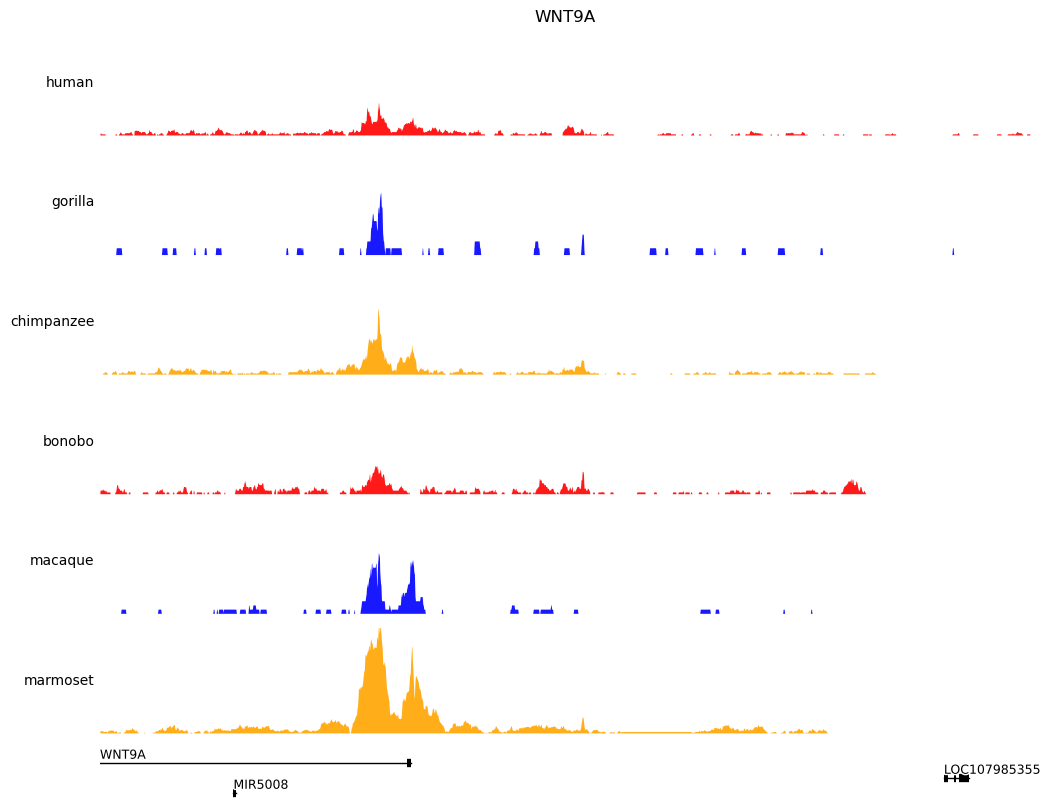

In [14]:
plot_genome_regions(bigwigs, regions,ymax=3,gtf_file="/cluster/home/jjanssens/jjans/analysis/cerebellum/genomes_code_test/homo_sapiens/hg38.refGene.gtf.gz",colors=['red','blue','orange'],track_names=['human','gorilla','chimpanzee','bonobo','macaque','marmoset'])

In [22]:
regions = {
    'LCT': 'chr2:135,818,543-135,871,877',
        "WNT9A": "chr1:227,936,813-227,970,089",

}

In [25]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import matplotlib.patheffects as PathEffects
import numpy as np
import pandas as pd
import seaborn as sns
import pyBigWig
import pybedtools
import re
import os

# --- Helper Functions ---

def parse_region(region_str):
    """Parses 'chr:start-end' string into (chrom, start, end)."""
    region_str = region_str.replace(',', '')
    chrom, coords = region_str.split(':')
    start, end = map(int, coords.split('-'))
    return chrom, start, end

def smooth_signal(y, window=20):
    if len(y) < window: return y
    box = np.ones(window) / window
    return np.convolve(y, box, mode='same')

def check_chrom_format(bedtool_obj, chrom):
    """Checks if the file uses 'chr' prefix and adjusts the query chrom."""
    try:
        first_interval = next(iter(bedtool_obj))
        file_has_chr = first_interval.chrom.startswith('chr')
        query_has_chr = chrom.startswith('chr')
        
        if file_has_chr and not query_has_chr:
            return 'chr' + chrom
        elif not file_has_chr and query_has_chr:
            return chrom.replace('chr', '')
        return chrom
    except StopIteration:
        return chrom

def get_gtf_features(gtf_file, chrom, start, end):
    if not gtf_file: return pd.DataFrame()
    gtf = pybedtools.BedTool(gtf_file)
    chrom_query = check_chrom_format(gtf, chrom)
    query_str = f'{chrom_query} {start} {end}'
    query = pybedtools.BedTool(query_str, from_string=True)
    hits = gtf.intersect(query, wa=True)
    
    if len(hits) == 0: return pd.DataFrame()
        
    df = hits.to_dataframe(names=['chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attributes'])
    
    def parse_attr(attr_str, key):
        m = re.search(f'{key}\s+"?([^";]+)"?', attr_str)
        return m.group(1) if m else None

    df['gene_name'] = df['attributes'].apply(lambda x: parse_attr(x, 'gene_name'))
    mask_nan = df['gene_name'].isna()
    if mask_nan.any():
        df.loc[mask_nan, 'gene_name'] = df.loc[mask_nan, 'attributes'].apply(lambda x: parse_attr(x, 'gene_id'))
    return df

# --- Main Plotting Function ---

def plot_genome_regions(bigwigs,
                        selected_regions,
                        gtf_file=None,
                        bed_tracks=None,
                        snp_file=None,      # NEW
                        snp_color='red',    # NEW
                        plot_coordinates=False, # NEW
                        relative_coords=False,  # NEW
                        colors=None,
                        track_names=None,
                        ymin=0, ymax=75,
                        figsize=(12, 10),
                        smooth_window=20,
                        saveas=None):
    
    # 1. Setup Data
    region_labels = list(selected_regions.keys())
    region_coords = [parse_region(r) for r in selected_regions.values()]
    n_regions = len(region_labels)
    n_bw = len(bigwigs)
    n_bed = len(bed_tracks) if bed_tracks else 0
    has_gtf = 1 if gtf_file else 0
    
    if track_names is None:
        track_names = [os.path.basename(x).split('.')[0] for x in bigwigs]
    
    if colors is None:
        colors = ['#333333'] * n_bw
    elif len(colors) < n_bw:
        from itertools import cycle
        colors = [c for c, _ in zip(cycle(colors), range(n_bw))]

    # 1.5 Pre-calculate SNPs for every region
    # This stores a list of SNP positions for each region index
    region_snps = {i: [] for i in range(n_regions)}
    if snp_file:
        snp_tool = pybedtools.BedTool(snp_file)
        for i, (chrom, start, end) in enumerate(region_coords):
            chrom_q = check_chrom_format(snp_tool, chrom)
            # Intersect
            hits = snp_tool.intersect(pybedtools.BedTool(f'{chrom_q} {start} {end}', from_string=True), wa=True)
            # Store absolute positions
            region_snps[i] = [x.start for x in hits]

    # 2. Setup Figure
    total_rows = n_bw + n_bed + has_gtf
    # Ratios: BigWigs=1, Bed=0.2, GTF=0.5
    height_ratios = [1.0] * n_bw + [0.2] * n_bed + ([0.5] if has_gtf else [])
    
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(total_rows, n_regions, 
                           height_ratios=height_ratios, 
                           wspace=0.1, hspace=0.15)

    # Helper to add SNPs to any current axis
    def add_snps_to_ax(ax, region_idx):
        snps = region_snps[region_idx]
        for snp_pos in snps:
            ax.axvline(snp_pos, color=snp_color, linestyle='-', linewidth=1, alpha=0.7, zorder=10)

    # 3. Plot BigWigs
    for row_idx, (bw_file, track_name, color) in enumerate(zip(bigwigs, track_names, colors)):
        bw = pyBigWig.open(bw_file)
        for col_idx, (label, (chrom, start, end)) in enumerate(zip(region_labels, region_coords)):
            ax = fig.add_subplot(gs[row_idx, col_idx])
            
            # Format chrom
            chrom_bw = chrom if chrom in bw.chroms() else ('chr'+chrom if 'chr'+chrom in bw.chroms() else chrom)
            
            try:
                values = bw.values(chrom_bw, start, end)
                values = np.nan_to_num(np.array(values))
                if smooth_window: values = smooth_signal(values, smooth_window)
                x = np.arange(start, end)
                ax.fill_between(x, values, color=color, alpha=0.9, linewidth=0)
            except Exception as e:
                print(f"BW Error {track_name}: {e}")

            ax.set_ylim(ymin, ymax)
            ax.set_xlim(start, end)
            add_snps_to_ax(ax, col_idx) # Add SNPs
            
            if col_idx == 0:
                ax.set_ylabel(track_name, rotation=0, ha='right', va='center', fontsize=10)
            
            # Clean axis
            ax.set_xticks([])
            ax.set_yticks([])
            sns.despine(ax=ax, left=True, bottom=True)
            
            if row_idx == 0:
                ax.set_title(label, fontsize=12)
        bw.close()

    current_row = n_bw

    # 4. Plot Bed Tracks
    if bed_tracks:
        for bed_file in bed_tracks:
            bed = pybedtools.BedTool(bed_file)
            for col_idx, (label, (chrom, start, end)) in enumerate(zip(region_labels, region_coords)):
                ax = fig.add_subplot(gs[current_row, col_idx])
                
                chrom_q = check_chrom_format(bed, chrom)
                hits = bed.intersect(pybedtools.BedTool(f'{chrom_q} {start} {end}', from_string=True), wa=True)
                
                for hit in hits:
                    h_start, h_end = max(start, hit.start), min(end, hit.end)
                    ax.plot([h_start, h_end], [0, 0], linewidth=6, color='#555555', solid_capstyle='butt')
                
                ax.set_xlim(start, end)
                add_snps_to_ax(ax, col_idx) # Add SNPs
                ax.axis('off')
            current_row += 1

    # 5. Plot GTF
    if has_gtf:
        for col_idx, (label, (chrom, start, end)) in enumerate(zip(region_labels, region_coords)):
            ax = fig.add_subplot(gs[current_row, col_idx])
            
            df = get_gtf_features(gtf_file, chrom, start, end)
            
            if not df.empty:
                df = df[(df['end'] > start) & (df['start'] < end)]
                genes = df['gene_name'].dropna().unique()
                if len(genes) == 0: genes = df['attributes'].unique()
                
                for i, gene in enumerate(genes):
                    y_pos = i % 3
                    sub = df[df['gene_name'] == gene]
                    if sub.empty: continue

                    g_start, g_end = sub['start'].min(), sub['end'].max()
                    ax.plot([max(start, g_start), min(end, g_end)], [y_pos, y_pos], c='k', lw=1)
                    
                    exons = sub[sub['feature'] == 'exon']
                    for _, ex in exons.iterrows():
                        ax.plot([max(start, ex['start']), min(end, ex['end'])], [y_pos, y_pos], 
                                c='k', lw=6, solid_capstyle='butt')
                    
                    txt = ax.text(max(start, g_start), y_pos + 0.25, gene, fontsize=9, ha='left')
                    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
                    
                ax.set_ylim(-0.5, 3)
            
            ax.set_xlim(start, end)
            add_snps_to_ax(ax, col_idx) # Add SNPs
            
            # 6. Coordinate Logic (Applied to the bottom-most track)
            if plot_coordinates:
                ax.axis('on') # Re-enable axis
                sns.despine(ax=ax, left=True, bottom=False, top=True, right=True)
                ax.set_yticks([])
                
                if relative_coords:
                    # Formatter: subtract 'start' from x
                    def rel_formatter(x, pos):
                        return f'{int(x - start):,}'
                    ax.xaxis.set_major_formatter(ticker.FuncFormatter(rel_formatter))
                    ax.set_xlabel("Relative Coordinate (bp)")
                else:
                    # Formatter: Comma separated absolute
                    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
                    
                ax.tick_params(axis='x', labelsize=8, rotation=0)
            else:
                ax.axis('off')

    # If no GTF but we want coords, we must apply them to the last existing row
    # This handles the case where users plot BigWigs only + Coords
    if not has_gtf and plot_coordinates:
        # Get axes from the last row
        last_row_axes = fig.get_axes()[-n_regions:]
        for i, ax in enumerate(last_row_axes):
            chrom, start, end = region_coords[i]
            ax.set_xticks(np.linspace(start, end, 4)) # ensure we have ticks
            sns.despine(ax=ax, left=True, bottom=False)
            
            if relative_coords:
                def rel_formatter(x, pos): return f'{int(x - start):,}'
                ax.xaxis.set_major_formatter(ticker.FuncFormatter(rel_formatter))
            else:
                ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
            ax.tick_params(axis='x', labelsize=8)

    # 7. Finalize
    if saveas:
        plt.savefig(saveas, dpi=300, bbox_inches='tight')
    else:
        plt.show()

In [29]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import matplotlib.patheffects as PathEffects
import numpy as np
import pandas as pd
import seaborn as sns
import pyBigWig
import pybedtools
import re
import os

# --- Helper Functions ---

def parse_region(region_str):
    region_str = region_str.replace(',', '')
    chrom, coords = region_str.split(':')
    start, end = map(int, coords.split('-'))
    return chrom, start, end

def smooth_signal(y, window=20):
    if len(y) < window: return y
    box = np.ones(window) / window
    return np.convolve(y, box, mode='same')

def check_chrom_format(bedtool_obj, chrom):
    try:
        first_interval = next(iter(bedtool_obj))
        file_has_chr = first_interval.chrom.startswith('chr')
        query_has_chr = chrom.startswith('chr')
        if file_has_chr and not query_has_chr: return 'chr' + chrom
        elif not file_has_chr and query_has_chr: return chrom.replace('chr', '')
        return chrom
    except StopIteration:
        return chrom

def get_gtf_features(gtf_file, chrom, start, end):
    if not gtf_file: return pd.DataFrame()
    gtf = pybedtools.BedTool(gtf_file)
    chrom_query = check_chrom_format(gtf, chrom)
    query_str = f'{chrom_query} {start} {end}'
    query = pybedtools.BedTool(query_str, from_string=True)
    hits = gtf.intersect(query, wa=True)
    if len(hits) == 0: return pd.DataFrame()
    df = hits.to_dataframe(names=['chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attributes'])
    def parse_attr(attr_str, key):
        m = re.search(f'{key}\s+"?([^";]+)"?', attr_str)
        return m.group(1) if m else None
    df['gene_name'] = df['attributes'].apply(lambda x: parse_attr(x, 'gene_name'))
    mask_nan = df['gene_name'].isna()
    if mask_nan.any():
        df.loc[mask_nan, 'gene_name'] = df.loc[mask_nan, 'attributes'].apply(lambda x: parse_attr(x, 'gene_id'))
    return df

# --- Main Plotting Function ---

def plot_genome_regions(bigwigs,
                        selected_regions,
                        gtf_file=None,
                        bed_tracks=None,
                        snp_file=None,
                        snp_color='red',
                        plot_coordinates=True, 
                        relative_coords=False,
                        colors=None,
                        track_names=None,
                        ymin=0, 
                        ymax=75, # Can be int or list of ints
                        figsize=(12, 10),
                        smooth_window=20,
                        saveas=None):
    
    # 1. Setup Data
    region_labels = list(selected_regions.keys())
    region_coords = [parse_region(r) for r in selected_regions.values()]
    n_regions = len(region_labels)
    n_bw = len(bigwigs)
    n_bed = len(bed_tracks) if bed_tracks else 0
    has_gtf = 1 if gtf_file else 0

    # Handle variable Y-limits
    if isinstance(ymax, (int, float)):
        ymax_list = [ymax] * n_regions
        vary_ylim = False
    else:
        if len(ymax) != n_regions:
            raise ValueError("Length of ymax list must match number of regions")
        ymax_list = ymax
        vary_ylim = True # Flag to show ticks on all columns
    
    if track_names is None:
        track_names = [os.path.basename(x).split('.')[0] for x in bigwigs]
    
    if colors is None:
        colors = ['#333333'] * n_bw
    elif len(colors) < n_bw:
        from itertools import cycle
        colors = [c for c, _ in zip(cycle(colors), range(n_bw))]

    # 1.5 Pre-calculate SNPs
    region_snps = {i: [] for i in range(n_regions)}
    if snp_file:
        snp_tool = pybedtools.BedTool(snp_file)
        for i, (chrom, start, end) in enumerate(region_coords):
            chrom_q = check_chrom_format(snp_tool, chrom)
            hits = snp_tool.intersect(pybedtools.BedTool(f'{chrom_q} {start} {end}', from_string=True), wa=True)
            region_snps[i] = [x.start for x in hits]

    # 2. Setup Figure
    total_rows = n_bw + n_bed + has_gtf
    height_ratios = [1.0] * n_bw + [0.2] * n_bed + ([0.5] if has_gtf else [])
    
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(total_rows, n_regions, 
                           height_ratios=height_ratios, 
                           wspace=0.15, hspace=0.2) # Increased wspace slightly for y-ticks

    def add_snps_to_ax(ax, region_idx):
        snps = region_snps[region_idx]
        for snp_pos in snps:
            ax.axvline(snp_pos, color=snp_color, linestyle='-', linewidth=1, alpha=0.7, zorder=10)

    # 3. Plot BigWigs
    for row_idx, (bw_file, track_name, color) in enumerate(zip(bigwigs, track_names, colors)):
        bw = pyBigWig.open(bw_file)
        for col_idx, (label, (chrom, start, end)) in enumerate(zip(region_labels, region_coords)):
            ax = fig.add_subplot(gs[row_idx, col_idx])
            
            # Determine specific ymax for this column
            current_ymax = ymax_list[col_idx]

            chrom_bw = chrom if chrom in bw.chroms() else ('chr'+chrom if 'chr'+chrom in bw.chroms() else chrom)
            try:
                values = bw.values(chrom_bw, start, end)
                values = np.nan_to_num(np.array(values))
                if smooth_window: values = smooth_signal(values, smooth_window)
                x = np.arange(start, end)
                ax.fill_between(x, values, color=color, alpha=0.9, linewidth=0)
            except Exception as e:
                print(f"BW Error {track_name}: {e}")

            ax.set_xlim(start, end)
            ax.set_ylim(ymin, current_ymax)
            add_snps_to_ax(ax, col_idx)
            
            # --- Y-Axis Handling ---
            # Set simple ticks: Min and Max only
            ax.set_yticks([ymin, current_ymax])
            
            # Label logic:
            # If limits vary, label every column.
            # If limits are constant, label only the first column.
            if col_idx == 0:
                ax.set_ylabel(track_name, rotation=0, ha='right', va='center', fontsize=10)
                # Always show labels on first column
                ax.tick_params(axis='y', labelsize=8)
            elif vary_ylim:
                # Show labels on other columns too if limits differ
                ax.tick_params(axis='y', labelsize=8)
            else:
                # Hide labels if limits are uniform (cleaner look)
                ax.set_yticklabels([])

            ax.set_xticks([])
            sns.despine(ax=ax, left=False, bottom=True, right=True, top=True)
            
            if row_idx == 0:
                ax.set_title(label, fontsize=12)
        bw.close()

    current_row = n_bw

    # 4. Plot Bed Tracks
    if bed_tracks:
        for bed_file in bed_tracks:
            bed = pybedtools.BedTool(bed_file)
            for col_idx, (label, (chrom, start, end)) in enumerate(zip(region_labels, region_coords)):
                ax = fig.add_subplot(gs[current_row, col_idx])
                chrom_q = check_chrom_format(bed, chrom)
                hits = bed.intersect(pybedtools.BedTool(f'{chrom_q} {start} {end}', from_string=True), wa=True)
                for hit in hits:
                    h_start, h_end = max(start, hit.start), min(end, hit.end)
                    ax.plot([h_start, h_end], [0, 0], linewidth=6, color='#555555', solid_capstyle='butt')
                ax.set_xlim(start, end)
                add_snps_to_ax(ax, col_idx)
                ax.axis('off')
            current_row += 1

    # 5. Plot GTF and/or Coordinates
    # We identify the last row used for plotting data to attach coordinates to
    final_data_row = current_row if has_gtf else current_row - 1
    
    if has_gtf:
        for col_idx, (label, (chrom, start, end)) in enumerate(zip(region_labels, region_coords)):
            ax = fig.add_subplot(gs[current_row, col_idx])
            df = get_gtf_features(gtf_file, chrom, start, end)
            if not df.empty:
                df = df[(df['end'] > start) & (df['start'] < end)]
                genes = df['gene_name'].dropna().unique()
                if len(genes) == 0: genes = df['attributes'].unique()
                for i, gene in enumerate(genes):
                    y_pos = i % 3
                    sub = df[df['gene_name'] == gene]
                    if sub.empty: continue
                    g_start, g_end = sub['start'].min(), sub['end'].max()
                    ax.plot([max(start, g_start), min(end, g_end)], [y_pos, y_pos], c='k', lw=1)
                    exons = sub[sub['feature'] == 'exon']
                    for _, ex in exons.iterrows():
                        ax.plot([max(start, ex['start']), min(end, ex['end'])], [y_pos, y_pos], c='k', lw=6)
                    txt = ax.text(max(start, g_start), y_pos + 0.25, gene, fontsize=9, ha='left')
                    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
                ax.set_ylim(-0.5, 3)
            ax.set_xlim(start, end)
            add_snps_to_ax(ax, col_idx)
            
            # If coordinates are requested, we format the axis of this last plot
            if plot_coordinates:
                ax.axis('on')
                sns.despine(ax=ax, left=True, bottom=False, top=True, right=True)
                ax.set_yticks([])
            else:
                ax.axis('off')

    # 6. Apply Coordinate Formatting (to the last row active)
    if plot_coordinates:
        # Get the axes that need labels (last row of the grid)
        # If GTF exists, they are already created above. If not, we grab the last bigwig/bed row.
        if has_gtf:
             axes_to_label = fig.get_axes()[-n_regions:]
        else:
             axes_to_label = fig.get_axes()[-n_regions:]
             
        for i, ax in enumerate(axes_to_label):
            chrom, start, end = region_coords[i]
            
            # --- Density Control ---
            # MaxNLocator with nbins=3 ensures we don't get overlapping text 
            # (e.g., start, middle, end)
            locator = ticker.MaxNLocator(nbins=3)
            ax.xaxis.set_major_locator(locator)
            
            # --- Label Formatting ---
            if relative_coords:
                def rel_formatter(x, pos): return f'{int(x - start):,}'
                ax.xaxis.set_major_formatter(ticker.FuncFormatter(rel_formatter))
                xlabel = f"{chrom} (relative)"
            else:
                ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
                xlabel = f"{chrom}"

            ax.set_xlabel(xlabel, fontsize=10)
            ax.tick_params(axis='x', labelsize=8)
            
            # Ensure the spine is visible if we didn't use GTF
            if not has_gtf:
                sns.despine(ax=ax, left=False, bottom=False, right=True, top=True)
                ax.set_yticks([]) # Hide y ticks for bigwigs on the bottom row if strict layout

    if saveas:
        plt.savefig(saveas, dpi=300, bbox_inches='tight')
    else:
        plt.show()

In [ ]:
SNCs = pd.read_csv("../data/SNC/Prufer_SNC_hg38_minimal.bed")

In [37]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import matplotlib.patheffects as PathEffects
from matplotlib.patches import ConnectionPatch
import numpy as np
import pandas as pd
import seaborn as sns
import pyBigWig
import pybedtools
import re
import os
import matplotlib

# --- Configuration for Editable Text in Vector Graphics ---
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# --- Helper Functions ---

def parse_region(region_str):
    region_str = region_str.replace(',', '')
    chrom, coords = region_str.split(':')
    start, end = map(int, coords.split('-'))
    return chrom, start, end

def smooth_signal(y, window=20):
    if len(y) < window: return y
    box = np.ones(window) / window
    return np.convolve(y, box, mode='same')

def check_chrom_format(bedtool_obj, chrom):
    try:
        first_interval = next(iter(bedtool_obj))
        file_has_chr = first_interval.chrom.startswith('chr')
        query_has_chr = chrom.startswith('chr')
        if file_has_chr and not query_has_chr: return 'chr' + chrom
        elif not file_has_chr and query_has_chr: return chrom.replace('chr', '')
        return chrom
    except StopIteration:
        return chrom

def get_gtf_features(gtf_file, chrom, start, end):
    if not gtf_file: return pd.DataFrame()
    gtf = pybedtools.BedTool(gtf_file)
    chrom_query = check_chrom_format(gtf, chrom)
    query_str = f'{chrom_query} {start} {end}'
    query = pybedtools.BedTool(query_str, from_string=True)
    hits = gtf.intersect(query, wa=True)
    if len(hits) == 0: return pd.DataFrame()
    
    df = hits.to_dataframe(names=['chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attributes'])
    
    def parse_attr(attr_str, key):
        m = re.search(f'{key}\s+"?([^";]+)"?', attr_str)
        return m.group(1) if m else None

    df['gene_name'] = df['attributes'].apply(lambda x: parse_attr(x, 'gene_name'))
    mask_nan = df['gene_name'].isna()
    if mask_nan.any():
        df.loc[mask_nan, 'gene_name'] = df.loc[mask_nan, 'attributes'].apply(lambda x: parse_attr(x, 'gene_id'))
    return df

# --- Main Plotting Function ---

def plot_genome_regions(bigwigs,
                        selected_regions,
                        gtf_file=None,
                        bed_tracks=None,
                        bed_track_names=None,  # NEW
                        snp_file=None,
                        snp_color='red',
                        plot_coordinates=True, 
                        relative_coords=False,
                        colors=None,
                        track_names=None,
                        ymin=0, 
                        ymax=75,
                        figsize=(12, 10),
                        smooth_window=20,
                        saveas=None):
    
    # 1. Setup Data
    region_labels = list(selected_regions.keys())
    region_coords = [parse_region(r) for r in selected_regions.values()]
    n_regions = len(region_labels)
    n_bw = len(bigwigs)
    n_bed = len(bed_tracks) if bed_tracks else 0
    has_gtf = 1 if gtf_file else 0

    # Handle Y-limits
    if isinstance(ymax, (int, float)):
        ymax_list = [ymax] * n_regions
        vary_ylim = False
    else:
        if len(ymax) != n_regions:
            raise ValueError("Length of ymax list must match number of regions")
        ymax_list = ymax
        vary_ylim = True 
    
    if track_names is None:
        track_names = [os.path.basename(x).split('.')[0] for x in bigwigs]
    
    # Handle Bed Track Names
    if bed_tracks and bed_track_names is None:
        bed_track_names = [os.path.basename(x).split('.')[0] for x in bed_tracks]
    
    if colors is None:
        colors = ['#333333'] * n_bw
    elif len(colors) < n_bw:
        from itertools import cycle
        colors = [c for c, _ in zip(cycle(colors), range(n_bw))]

    # 1.5 Pre-calculate SNPs
    region_snps = {i: [] for i in range(n_regions)}
    if snp_file:
        snp_tool = pybedtools.BedTool(snp_file)
        for i, (chrom, start, end) in enumerate(region_coords):
            chrom_q = check_chrom_format(snp_tool, chrom)
            hits = snp_tool.intersect(pybedtools.BedTool(f'{chrom_q} {start} {end}', from_string=True), wa=True)
            region_snps[i] = [x.start for x in hits]

    # 2. Setup Figure
    total_rows = n_bw + n_bed + has_gtf
    height_ratios = [1.0] * n_bw + [0.2] * n_bed + ([0.5] if has_gtf else [])
    
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(total_rows, n_regions, 
                           height_ratios=height_ratios, 
                           wspace=0.15, hspace=0.1)

    # To draw continuous lines, we need to track the top and bottom axes for each column
    col_axes_limits = {i: {'top': None, 'bottom': None} for i in range(n_regions)}

    # 3. Plot BigWigs
    for row_idx, (bw_file, track_name, color) in enumerate(zip(bigwigs, track_names, colors)):
        bw = pyBigWig.open(bw_file)
        for col_idx, (label, (chrom, start, end)) in enumerate(zip(region_labels, region_coords)):
            ax = fig.add_subplot(gs[row_idx, col_idx])
            
            # Store axes for line drawing
            if row_idx == 0: col_axes_limits[col_idx]['top'] = ax
            col_axes_limits[col_idx]['bottom'] = ax # Temporarily update bottom
            
            current_ymax = ymax_list[col_idx]
            chrom_bw = chrom if chrom in bw.chroms() else ('chr'+chrom if 'chr'+chrom in bw.chroms() else chrom)
            
            try:
                values = bw.values(chrom_bw, start, end)
                values = np.nan_to_num(np.array(values))
                if smooth_window: values = smooth_signal(values, smooth_window)
                x = np.arange(start, end)
                ax.fill_between(x, values, color=color, alpha=0.9, linewidth=0)
            except Exception as e:
                print(f"BW Error {track_name}: {e}")

            ax.set_xlim(start, end)
            ax.set_ylim(ymin, current_ymax)
            
            # Y-Axis Logic
            ax.set_yticks([ymin, current_ymax])
            if col_idx == 0:
                ax.set_ylabel(track_name, rotation=0, ha='right', va='center', fontsize=10)
                ax.tick_params(axis='y', labelsize=8)
            elif vary_ylim:
                ax.tick_params(axis='y', labelsize=8)
            else:
                ax.set_yticklabels([])

            ax.set_xticks([])
            sns.despine(ax=ax, left=False, bottom=True, right=True, top=True)
            if row_idx == 0: ax.set_title(label, fontsize=12)
        bw.close()

    current_row = n_bw

    # 4. Plot Bed Tracks
    if bed_tracks:
        for i, bed_file in enumerate(bed_tracks):
            bed = pybedtools.BedTool(bed_file)
            track_name = bed_track_names[i]
            
            for col_idx, (label, (chrom, start, end)) in enumerate(zip(region_labels, region_coords)):
                ax = fig.add_subplot(gs[current_row, col_idx])
                col_axes_limits[col_idx]['bottom'] = ax # Update bottom
                
                chrom_q = check_chrom_format(bed, chrom)
                hits = bed.intersect(pybedtools.BedTool(f'{chrom_q} {start} {end}', from_string=True), wa=True)
                for hit in hits:
                    h_start, h_end = max(start, hit.start), min(end, hit.end)
                    ax.plot([h_start, h_end], [0, 0], linewidth=6, color='#555555', solid_capstyle='butt')
                ax.set_xlim(start, end)
                ax.set_ylim(-1, 1)
                ax.axis('off')
                
                # Add Name to the left-most plot
                if col_idx == 0:
                    ax.axis('on')
                    sns.despine(ax=ax, left=True, bottom=True, top=True, right=True)
                    ax.set_yticks([])
                    ax.set_xticks([])
                    ax.set_ylabel(track_name, rotation=0, ha='right', va='center', fontsize=10)

            current_row += 1

    # 5. Plot GTF
    if has_gtf:
        for col_idx, (label, (chrom, start, end)) in enumerate(zip(region_labels, region_coords)):
            ax = fig.add_subplot(gs[current_row, col_idx])
            col_axes_limits[col_idx]['bottom'] = ax # Update bottom
            
            df = get_gtf_features(gtf_file, chrom, start, end)
            if not df.empty:
                df = df[(df['end'] > start) & (df['start'] < end)]
                genes = df['gene_name'].dropna().unique()
                if len(genes) == 0: genes = df['attributes'].unique()
                for i, gene in enumerate(genes):
                    y_pos = i % 3
                    sub = df[df['gene_name'] == gene]
                    if sub.empty: continue
                    g_start, g_end = sub['start'].min(), sub['end'].max()
                    ax.plot([max(start, g_start), min(end, g_end)], [y_pos, y_pos], c='k', lw=1)
                    exons = sub[sub['feature'] == 'exon']
                    for _, ex in exons.iterrows():
                        ax.plot([max(start, ex['start']), min(end, ex['end'])], [y_pos, y_pos], c='k', lw=6)
                    txt = ax.text(max(start, g_start), y_pos + 0.25, gene, fontsize=9, ha='left')
                    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
                ax.set_ylim(-0.5, 3)
            ax.set_xlim(start, end)
            
            if plot_coordinates:
                ax.axis('on')
                sns.despine(ax=ax, left=True, bottom=False, top=True, right=True)
                ax.set_yticks([])
            else:
                ax.axis('off')

    # 6. Draw Continuous SNPs (Across subplots)
    if snp_file:
        for col_idx in range(n_regions):
            snps = region_snps[col_idx]
            top_ax = col_axes_limits[col_idx]['top']
            bottom_ax = col_axes_limits[col_idx]['bottom']
            
            if top_ax and bottom_ax:
                top_ylim = top_ax.get_ylim()[1]
                bottom_ylim = bottom_ax.get_ylim()[0]
                
                for snp in snps:
                    # ConnectionPatch allows drawing lines between points in different axes
                    # We connect (snp, max_y) in top axis to (snp, min_y) in bottom axis
                    con = ConnectionPatch(xyA=(snp, top_ylim), xyB=(snp, bottom_ylim), 
                                          coordsA="data", coordsB="data",
                                          axesA=top_ax, axesB=bottom_ax,
                                          color=snp_color, linewidth=1, alpha=0.7, zorder=20)
                    fig.add_artist(con)

    # 7. Apply Coordinate Formatting
    if plot_coordinates:
        axes_to_label = fig.get_axes()[-n_regions:]
        for i, ax in enumerate(axes_to_label):
            chrom, start, end = region_coords[i]
            locator = ticker.MaxNLocator(nbins=3)
            ax.xaxis.set_major_locator(locator)
            
            if relative_coords:
                def rel_formatter(x, pos): return f'{int(x - start):,}'
                ax.xaxis.set_major_formatter(ticker.FuncFormatter(rel_formatter))
                xlabel = f"{chrom} (relative)"
            else:
                ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
                xlabel = f"{chrom}"

            ax.set_xlabel(xlabel, fontsize=10)
            ax.tick_params(axis='x', labelsize=8)
            if not has_gtf:
                sns.despine(ax=ax, left=False, bottom=False, right=True, top=True)

    if saveas:
        plt.savefig(saveas, dpi=300, bbox_inches='tight')
    else:
        plt.show()

In [40]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import matplotlib.patheffects as PathEffects
from matplotlib.patches import ConnectionPatch
import numpy as np
import pandas as pd
import seaborn as sns
import pyBigWig
import pybedtools
import re
import os
import matplotlib

# --- Configuration for Editable Text in Vector Graphics ---
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# --- Helper Functions ---

def parse_region(region_str):
    region_str = region_str.replace(',', '')
    chrom, coords = region_str.split(':')
    start, end = map(int, coords.split('-'))
    return chrom, start, end

def smooth_signal(y, window=20):
    if len(y) < window: return y
    box = np.ones(window) / window
    return np.convolve(y, box, mode='same')

def check_chrom_format(bedtool_obj, chrom):
    try:
        first_interval = next(iter(bedtool_obj))
        file_has_chr = first_interval.chrom.startswith('chr')
        query_has_chr = chrom.startswith('chr')
        if file_has_chr and not query_has_chr: return 'chr' + chrom
        elif not file_has_chr and query_has_chr: return chrom.replace('chr', '')
        return chrom
    except StopIteration:
        return chrom

def get_gtf_features(gtf_file, chrom, start, end):
    if not gtf_file: return pd.DataFrame()
    gtf = pybedtools.BedTool(gtf_file)
    chrom_query = check_chrom_format(gtf, chrom)
    query_str = f'{chrom_query} {start} {end}'
    query = pybedtools.BedTool(query_str, from_string=True)
    hits = gtf.intersect(query, wa=True)
    if len(hits) == 0: return pd.DataFrame()
    
    df = hits.to_dataframe(names=['chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attributes'])
    
    def parse_attr(attr_str, key):
        m = re.search(f'{key}\s+"?([^";]+)"?', attr_str)
        return m.group(1) if m else None

    df['gene_name'] = df['attributes'].apply(lambda x: parse_attr(x, 'gene_name'))
    mask_nan = df['gene_name'].isna()
    if mask_nan.any():
        df.loc[mask_nan, 'gene_name'] = df.loc[mask_nan, 'attributes'].apply(lambda x: parse_attr(x, 'gene_id'))
    return df

# --- Main Plotting Function ---

def plot_genome_regions(bigwigs,
                        selected_regions,
                        gtf_file=None,
                        bed_tracks=None,
                        bed_track_names=None,
                        snp_file=None,
                        snp_color='red',
                        plot_zero_line=False,  # NEW
                        zero_line_width=1,     # NEW
                        plot_coordinates=True, 
                        relative_coords=False,
                        colors=None,
                        track_names=None,
                        ymin=0, 
                        ymax=75,
                        figsize=(12, 10),
                        smooth_window=20,
                        saveas=None):
    
    # 1. Setup Data
    region_labels = list(selected_regions.keys())
    region_coords = [parse_region(r) for r in selected_regions.values()]
    n_regions = len(region_labels)
    n_bw = len(bigwigs)
    n_bed = len(bed_tracks) if bed_tracks else 0
    has_gtf = 1 if gtf_file else 0

    if isinstance(ymax, (int, float)):
        ymax_list = [ymax] * n_regions
        vary_ylim = False
    else:
        if len(ymax) != n_regions:
            raise ValueError("Length of ymax list must match number of regions")
        ymax_list = ymax
        vary_ylim = True 
    
    if track_names is None:
        track_names = [os.path.basename(x).split('.')[0] for x in bigwigs]
    
    if bed_tracks and bed_track_names is None:
        bed_track_names = [os.path.basename(x).split('.')[0] for x in bed_tracks]
    
    if colors is None:
        colors = ['#333333'] * n_bw
    elif len(colors) < n_bw:
        from itertools import cycle
        colors = [c for c, _ in zip(cycle(colors), range(n_bw))]

    # 1.5 Pre-calculate SNPs
    region_snps = {i: [] for i in range(n_regions)}
    if snp_file:
        snp_tool = pybedtools.BedTool(snp_file)
        for i, (chrom, start, end) in enumerate(region_coords):
            chrom_q = check_chrom_format(snp_tool, chrom)
            hits = snp_tool.intersect(pybedtools.BedTool(f'{chrom_q} {start} {end}', from_string=True), wa=True)
            region_snps[i] = [x.start for x in hits]

    # 2. Setup Figure
    total_rows = n_bw + n_bed + has_gtf
    height_ratios = [1.0] * n_bw + [0.2] * n_bed + ([0.5] if has_gtf else [])
    
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(total_rows, n_regions, 
                           height_ratios=height_ratios, 
                           wspace=0.15, hspace=0.1)

    col_axes_limits = {i: {'top': None, 'bottom': None} for i in range(n_regions)}

    # 3. Plot BigWigs
    for row_idx, (bw_file, track_name, color) in enumerate(zip(bigwigs, track_names, colors)):
        bw = pyBigWig.open(bw_file)
        for col_idx, (label, (chrom, start, end)) in enumerate(zip(region_labels, region_coords)):
            ax = fig.add_subplot(gs[row_idx, col_idx])
            
            if row_idx == 0: col_axes_limits[col_idx]['top'] = ax
            col_axes_limits[col_idx]['bottom'] = ax 
            
            current_ymax = ymax_list[col_idx]
            chrom_bw = chrom if chrom in bw.chroms() else ('chr'+chrom if 'chr'+chrom in bw.chroms() else chrom)
            
            try:
                values = bw.values(chrom_bw, start, end)
                values = np.nan_to_num(np.array(values))
                if smooth_window: values = smooth_signal(values, smooth_window)
                x = np.arange(start, end)
                ax.fill_between(x, values, color=color, alpha=0.9, linewidth=0)
            except Exception as e:
                print(f"BW Error {track_name}: {e}")

            ax.set_xlim(start, end)
            ax.set_ylim(ymin, current_ymax)
            
            # --- New: Zero Line ---
            if plot_zero_line:
                ax.axhline(0, color='black', linewidth=zero_line_width, zorder=1)

            # Y-Axis Logic
            ax.set_yticks([ymin, current_ymax])
            if col_idx == 0:
                ax.set_ylabel(track_name, rotation=0, ha='right', va='center', fontsize=10)
                ax.tick_params(axis='y', labelsize=8)
            elif vary_ylim:
                ax.tick_params(axis='y', labelsize=8)
            else:
                ax.set_yticklabels([])

            ax.set_xticks([])
            sns.despine(ax=ax, left=False, bottom=True, right=True, top=True)
            if row_idx == 0: ax.set_title(label, fontsize=12)
        bw.close()

    current_row = n_bw

    # 4. Plot Bed Tracks
    if bed_tracks:
        for i, bed_file in enumerate(bed_tracks):
            bed = pybedtools.BedTool(bed_file)
            track_name = bed_track_names[i]
            
            for col_idx, (label, (chrom, start, end)) in enumerate(zip(region_labels, region_coords)):
                ax = fig.add_subplot(gs[current_row, col_idx])
                col_axes_limits[col_idx]['bottom'] = ax 
                
                chrom_q = check_chrom_format(bed, chrom)
                hits = bed.intersect(pybedtools.BedTool(f'{chrom_q} {start} {end}', from_string=True), wa=True)
                for hit in hits:
                    h_start, h_end = max(start, hit.start), min(end, hit.end)
                    ax.plot([h_start, h_end], [0, 0], linewidth=6, color='#555555', solid_capstyle='butt')
                ax.set_xlim(start, end)
                ax.set_ylim(-1, 1)
                ax.axis('off')
                
                if col_idx == 0:
                    ax.axis('on')
                    sns.despine(ax=ax, left=True, bottom=True, top=True, right=True)
                    ax.set_yticks([])
                    ax.set_xticks([])
                    ax.set_ylabel(track_name, rotation=0, ha='right', va='center', fontsize=10)

            current_row += 1

    # 5. Plot GTF
    if has_gtf:
        for col_idx, (label, (chrom, start, end)) in enumerate(zip(region_labels, region_coords)):
            ax = fig.add_subplot(gs[current_row, col_idx])
            col_axes_limits[col_idx]['bottom'] = ax
            
            df = get_gtf_features(gtf_file, chrom, start, end)
            if not df.empty:
                df = df[(df['end'] > start) & (df['start'] < end)]
                genes = df['gene_name'].dropna().unique()
                if len(genes) == 0: genes = df['attributes'].unique()
                for i, gene in enumerate(genes):
                    y_pos = i % 3
                    sub = df[df['gene_name'] == gene]
                    if sub.empty: continue
                    g_start, g_end = sub['start'].min(), sub['end'].max()
                    ax.plot([max(start, g_start), min(end, g_end)], [y_pos, y_pos], c='k', lw=1)
                    exons = sub[sub['feature'] == 'exon']
                    for _, ex in exons.iterrows():
                        ax.plot([max(start, ex['start']), min(end, ex['end'])], [y_pos, y_pos], c='k', lw=6)
                    txt = ax.text(max(start, g_start), y_pos + 0.25, gene, fontsize=9, ha='left')
                    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
                ax.set_ylim(-0.5, 3)
            ax.set_xlim(start, end)
            
            if plot_coordinates:
                ax.axis('on')
                sns.despine(ax=ax, left=True, bottom=False, top=True, right=True)
                ax.set_yticks([])
            else:
                ax.axis('off')

    # 6. Draw Continuous SNPs
    if snp_file:
        for col_idx in range(n_regions):
            snps = region_snps[col_idx]
            top_ax = col_axes_limits[col_idx]['top']
            bottom_ax = col_axes_limits[col_idx]['bottom']
            
            if top_ax and bottom_ax:
                top_ylim = top_ax.get_ylim()[1]
                bottom_ylim = bottom_ax.get_ylim()[0]
                
                for snp in snps:
                    con = ConnectionPatch(xyA=(snp, top_ylim), xyB=(snp, bottom_ylim), 
                                          coordsA="data", coordsB="data",
                                          axesA=top_ax, axesB=bottom_ax,
                                          color=snp_color, linewidth=1, alpha=0.7, zorder=20)
                    fig.add_artist(con)

    # 7. Apply Coordinate Formatting
    if plot_coordinates:
        axes_to_label = fig.get_axes()[-n_regions:]
        for i, ax in enumerate(axes_to_label):
            chrom, start, end = region_coords[i]
            locator = ticker.MaxNLocator(nbins=3)
            ax.xaxis.set_major_locator(locator)
            
            if relative_coords:
                def rel_formatter(x, pos): return f'{int(x - start):,}'
                ax.xaxis.set_major_formatter(ticker.FuncFormatter(rel_formatter))
                xlabel = f"{chrom} (relative)"
            else:
                ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
                xlabel = f"{chrom}"

            ax.set_xlabel(xlabel, fontsize=10)
            ax.tick_params(axis='x', labelsize=8)
            if not has_gtf:
                sns.despine(ax=ax, left=False, bottom=False, right=True, top=True)

    if saveas:
        plt.savefig(saveas, dpi=300, bbox_inches='tight')
    else:
        plt.show()

In [47]:
regions = {
    'LCT': 'chr2:135,818,543-135,871,877',
    "WNT9A": "chr1:227,936,813-227,970,089",
    "PRSS1": "chr7:142,681,470-142,812,572"

}

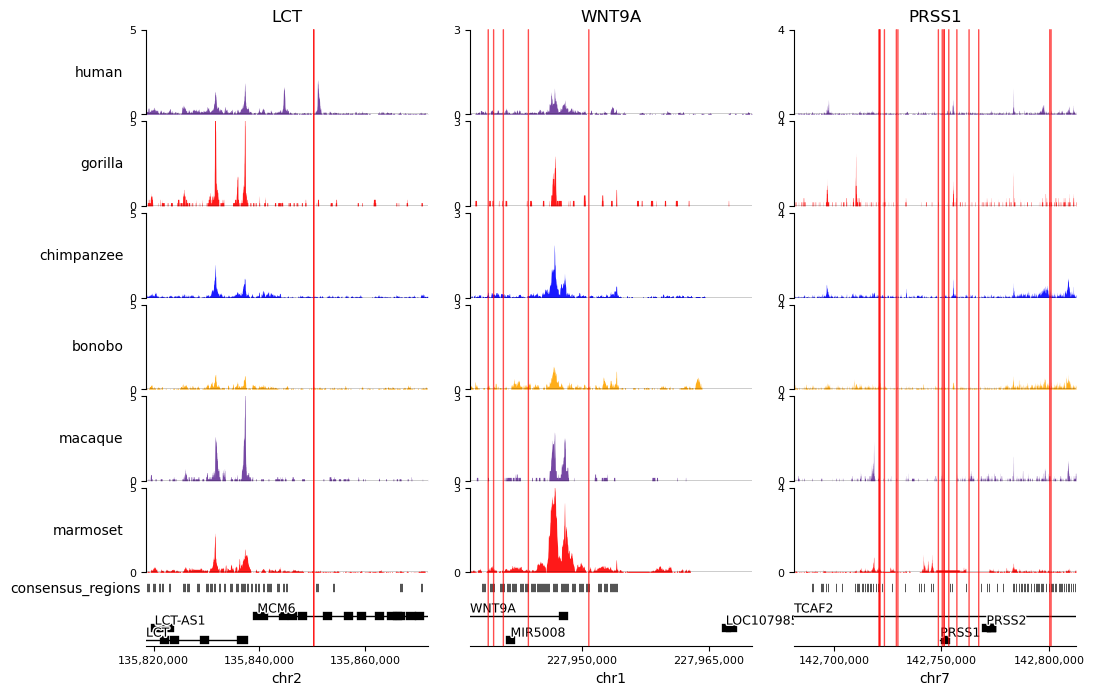

In [49]:
plot_genome_regions(bigwigs, regions,ymax=[5,3,4],smooth_window=20,plot_zero_line=True,figsize=(12,8), snp_file='../data/SNC/Prufer_SNC_hg38_minimal.bed',
                    bed_tracks=['../../atac/consensus_peak_calling_Human_filter/consensus_regions.bed'],
                    gtf_file="/cluster/home/jjanssens/jjans/analysis/cerebellum/genomes_code_test/homo_sapiens/hg38.refGene.gtf.gz",
                    colors=['rebeccapurple','red','blue','orange'],
                    track_names=['human','gorilla','chimpanzee','bonobo','macaque','marmoset'],
                    plot_coordinates=True)

In [50]:
regions = {
    "PRSS1": "chr7:142,681,470-142,812,572"
}

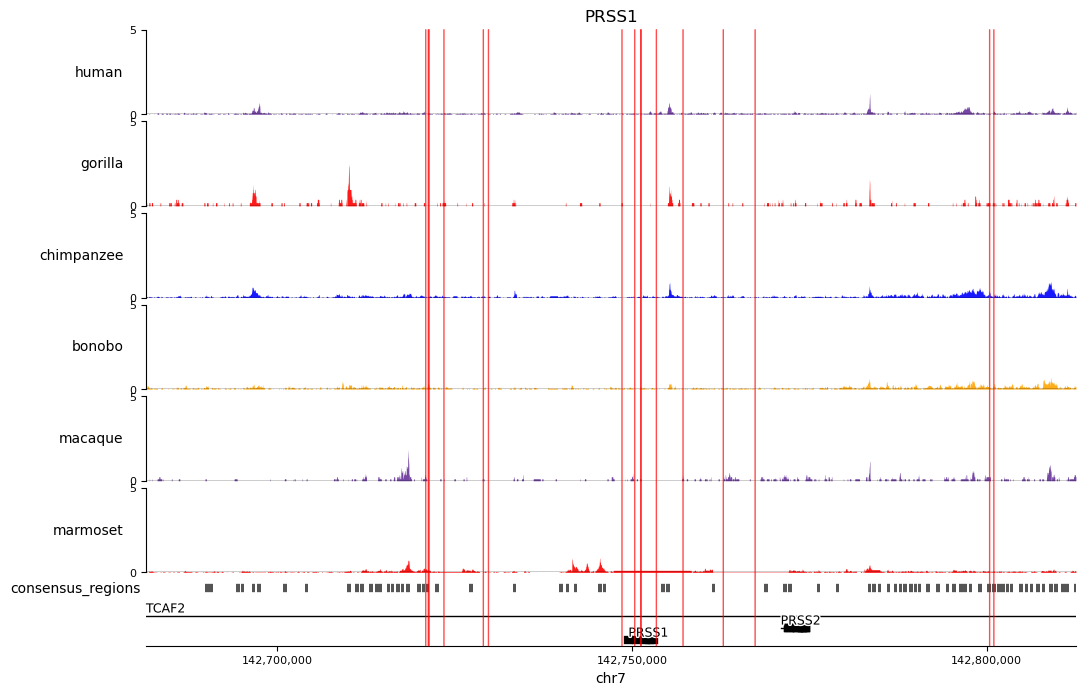

In [52]:
plot_genome_regions(bigwigs, regions,ymax=[5],smooth_window=20,plot_zero_line=True,figsize=(12,8), snp_file='../data/SNC/Prufer_SNC_hg38_minimal.bed',
                    bed_tracks=['../../atac/consensus_peak_calling_Human_filter/consensus_regions.bed'],
                    gtf_file="/cluster/home/jjanssens/jjans/analysis/cerebellum/genomes_code_test/homo_sapiens/hg38.refGene.gtf.gz",
                    colors=['rebeccapurple','red','blue','orange'],
                    track_names=['human','gorilla','chimpanzee','bonobo','macaque','marmoset'],
                    plot_coordinates=True)